In [175]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Load Data

In [176]:
train_data=np.load('s1_train.npy',allow_pickle=True)
test_data=np.load('s1_test.npy',allow_pickle=True)

## plot some PPG signal from s1_train dataset

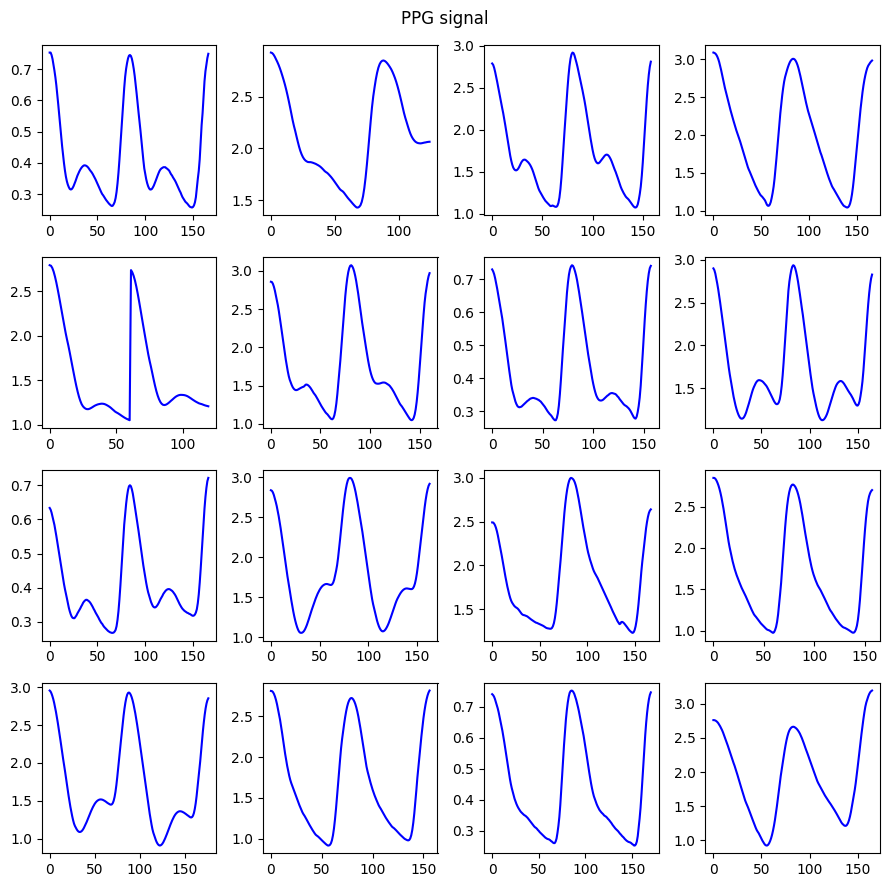

In [ ]:
num_plots = 4
fig_size = (9, 9)

# Calculate the number of rows and columns for the subplot grid
num_rows = num_plots
num_cols = num_plots

plt.figure(figsize=fig_size)

for plot_counter in range(1, num_plots * num_plots + 1):
    plt.subplot(num_rows, num_cols, plot_counter)
    plt.plot(train_data[plot_counter - 1][0], color='b')

plt.suptitle("PPG signal")
plt.tight_layout()
plt.savefig('output.png', dpi=1200, format='png', bbox_inches='tight')
plt.show()

##  PDF Report- plot all signals in the pdf file

This is to check all signals and detect any abnormal signals.

In [ ]:
num_plots = 48
num_rows = 4
num_cols = 5

with PdfPages(r'ppg_phase1.pdf') as export_pdf:
    for t in range(num_plots):
        fig = plt.figure(figsize=(12, 12))
        plt.suptitle("PPG signal")

        for c, s in enumerate(range(t * num_rows * num_cols, (t + 1) * num_rows * num_cols)):
            i, j = divmod(c, num_cols)
            plt.subplot(num_rows, num_cols, c + 1)
            plt.plot(train_data[s][0], color='b')
            plt.title(s)

        plt.tight_layout()
        export_pdf.savefig()
        plt.close()

## Preprocessing

Normalize Signal

In [177]:
# Loop over each row (i) in data_train
for i in range(train_data.shape[0]):
    min_val = np.min(train_data[i][0])
    max_val = np.max(train_data[i][0])

    # Check if max and min are not equal (avoid division by zero)
    if max_val != min_val:
        train_data[i][0] = (train_data[i][0] - min_val) / (max_val - min_val)

### delet short signal (length<150 ms)

In [178]:
# Create a list of indices to remove
short_signal = [i for i in range(960) if len(train_data[i][0]) < 150]

# Remove the selected indices from the numpy array
data_train = np.delete(train_data, short_signal, axis=0)

In [179]:
np.shape(train_data)

(1000, 2)

# Base-line **Model**

In [180]:
# Calculate the mean of data_train[i][1] using NumPy
y = np.mean(train_data[:, 1])

print('Y:', y)

# Calculate the baseline RMSE using NumPy
base_line_rmse = np.sqrt(np.mean((y - train_data[:, 1]) ** 2))

print('Base line RMSE:', base_line_rmse)

Y: 131.06994981998724
Base line RMSE: 25.7095357794773


# Main Model

### Upsampling - set signals' length to 200 ms

In [181]:
def upsample_signal(signal, target_length):
    # Calculate the factor by which to upsample the signal
    upsample_factor = target_length / len(signal)

    # Create an array with the target length
    upsampled_signal = np.zeros(target_length)

    # Linearly interpolate the values
    for i in range(target_length):
        index = i / upsample_factor
        lower_index = int(index)
        upper_index = min(lower_index + 1, len(signal) - 1)
        fractional_part = index - lower_index

        if lower_index == upper_index:
            upsampled_signal[i] = signal[lower_index]
        else:
            upsampled_signal[i] = (1 - fractional_part) * signal[lower_index] + fractional_part * signal[upper_index]

    return upsampled_signal

In [189]:
target_length = 200
for i in range(np.shape(train_data)[0]):

  train_data[i][0] = upsample_signal(train_data[i][0], target_length)

In [190]:
target_length = 200
for i in range(np.shape(test_data)[0]):

  test_data[i][0] = upsample_signal(test_data[i][0], target_length)

## linear regression

### Split dataset

In [192]:
y_train = np.ones((np.shape(train_data)[0]))
X_train = np.ones((np.shape(train_data)[0],200))

for i in range(np.shape(train_data)[0]):
   y_train[i] = train_data[i][1]
   X_train[i][:] = train_data[i][0]

In [193]:
X_test = np.ones((np.shape(test_data)[0],200))

for i in range(np.shape(test_data)[0]):
   X_test[i] = test_data[i][0]

### Define and fit the linear regression model

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math


# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

#Make predictions on the test data
y_train_pred = model.predict(X_train)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_train_pred)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

#Make predictions on the test data
y_pred = model.predict(X_test)

file_name = "linear_regression_prediction.txt"

# Save the array to a text file
np.savetxt(file_name, y_pred, fmt='%d', delimiter='\t')

print(f"Array saved to {file_name}")

MSE: 472.9579600685149
RMSE: 21.747596650400588
Array saved to linear_regression_prediction.txt


## Ridge Regression

In [200]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from numpy import arange
from sklearn.model_selection import GridSearchCV
# define model
model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
model = search.fit(X_train, y_train)

#Make predictions on the test data
y_train_pred = model.predict(X_train)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_train_pred)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

#Make predictions on the test data
y_pred = model.predict(X_test)

file_name = "ridge_regression_prediction.txt"

# Save the array to a text file
np.savetxt(file_name, y_pred, fmt='%d', delimiter='\t')

print(f"Array saved to {file_name}")

MSE: 589.7135873790749
RMSE: 24.284019176797624
Array saved to ridge_regression_prediction.txt


## Lasso

In [201]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Lasso

# Define the Lasso regression model
lasso_model = Lasso()

# Define the parameter grid for grid search
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}

# Create a k-fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=kf)

# Fit the model with grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Get the best model
best_model = grid_search.best_estimator_

# Fit the best model on the full training data
best_model.fit(X_train, y_train)

#Make predictions on the test data
y_train_pred = model.predict(X_train)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_train_pred)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

file_name = "lasso_prediction.txt"

# Save the array to a text file
np.savetxt(file_name, y_pred, fmt='%d', delimiter='\t')

print(f"Array saved to {file_name}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e+04, tolerance: 5.279e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e+04, tolerance: 5.167e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e+04, tolerance: 5.369e

Best alpha: 0.01
MSE: 589.7135873790749
RMSE: 24.284019176797624
Array saved to lasso_prediction.txt


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+04, tolerance: 6.610e+01
  model = cd_fast.enet_coordinate_descent(
